In [1]:
import math
from datetime import datetime as dt
import numpy as np
import pandas as pd
import collections
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from category_encoders.binary import BinaryEncoder
pd.set_option('display.max_columns', None)
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)

In [2]:
data = pd.read_excel("E:\\OneDrive - ФГБОУ ВО УГАТУ\\!ML\\BMM\\БММ 2.xlsx")
# data = data.drop_duplicates()#Выкинем дубликаты
data = data.fillna('Неизвестно')
data['Время конверсии'] = pd.to_datetime(data['Время конверсии'])#Переведем время конверсии
data

Оффер     Время конверсии    Статус Поисковая система  \
0          Быстроденьги 2022-07-27 18:49:00      lead        Неизвестно   
1              Екапуста 2022-07-27 18:54:00      lead        Неизвестно   
2              ДжойМани 2022-07-27 18:54:00      lead        Неизвестно   
3             Турбозайм 2022-07-27 18:55:00      lead              Гугл   
4          Белка Кредит 2022-07-27 18:56:00      lead        Неизвестно   
...                 ...                 ...       ...               ...   
2159             Займер 2022-07-29 13:25:00      sale              Гугл   
2160      Деньги на дом 2022-07-29 13:26:00  rejected        Неизвестно   
2161  Отличные наличные 2022-07-29 13:27:00      lead            Яндекс   
2162           ДжойМани 2022-07-29 13:27:00      lead              Гугл   
2163        Вива Деньги 2022-07-29 13:30:00      lead        Неизвестно   

     Плохая кредитная история Возрастная группа Безработные  \
0                  Неизвестно        Неизвестно  Неизвестно   
1                  Неизвестно        Неизвестно  Неизвестно   
2                  Неизвестно        Неизвестно  Неизвестно   
3                  Неизвестно        Неизвестно  Неизвестно   
4                  Неизвестно        Неизвестно  Неизвестно   
...                       ...               ...         ...   
2159                       Да        Неизвестно  Неизвестно   
2160               Неизвестно        Неизвестно  Неизвестно   
2161               Неизвестно        Неизвестно  Неизвестно   
2162                       Да        Неизвестно  Неизвестно   
2163               Неизвестно        Неизвестно  Неизвестно   

     Читают отзывы перед оформлением                Город     Тип устройства  \
0                         Неизвестно                Myski  Мобильный телефон   
1                         Неизвестно         Magnitogorsk  Мобильный телефон   
2                         Неизвестно          Novosibirsk  Мобильный телефон   
3                         Неизвестно             Noyabrsk  Мобильный телефон   
4                         Неизвестно  Naberezhnyye Chelny  Мобильный телефон   
...                              ...                  ...                ...   
2159                      Неизвестно                Aksay  Мобильный телефон   
2160                      Неизвестно               Moscow  Мобильный телефон   
2161                      Неизвестно             Turochak  Мобильный телефон   
2162                      Неизвестно             Shikotan  Мобильный телефон   
2163                      Неизвестно            Vityazevo  Мобильный телефон   

                                              UserAgent       ОС  \
0     Mozilla/5.0 (iPhone; CPU iPhone OS 15_5 like M...      iOS   
1     Mozilla/5.0 (iPhone; CPU iPhone OS 15_2 like M...      iOS   
2     Mozilla/5.0 (Linux; Android 12; SM-G991B) Appl...  Android   
3     Mozilla/5.0 (Linux; Android 9; SM-J600F) Apple...  Android   
4     Mozilla/5.0 (iPhone; CPU iPhone OS 15_0_1 like...      iOS   
...                                                 ...      ...   
2159  Mozilla/5.0 (iPhone; CPU iPhone OS 12_5_5 like...      iOS   
2160  Mozilla/5.0 (iPhone; CPU iPhone OS 15_5 like M...      iOS   
2161  Mozilla/5.0 (Linux; arm_64; Android 11; SM-M12...  Android   
2162  Mozilla/5.0 (Linux; Android 10; VOG-L29) Apple...  Android   
2163  Mozilla/5.0 (iPhone; CPU iPhone OS 15_5 like M...      iOS   

                Версия ОС         Браузер      Версия браузера  \
0     2022-05-15 00:00:00   Mobile Safari  2022-05-15 00:00:00   
1     2022-02-15 00:00:00   Mobile Safari  2022-02-15 00:00:00   
2                      12   Chrome Mobile            102.0.0.0   
3                       9   Chrome Mobile            103.0.0.0   
4                  15.0.1   Mobile Safari                 15.0   
...                   ...             ...                  ...   
2159  2005-05-12 00:00:00   Mobile Safari  2002-01-12 00:00:00   
2160  2022-05-15 00:00:00   Mobile Safari  2022-05-15 

# Корреляционный анализ

In [3]:
data = data.drop(['Время конверсии',
'Плохая кредитная история',
'Возрастная группа',
'Безработные',
'Читают отзывы перед оформлением',
'Город',
'ОС',
'Поисковая система',
'UserAgent',
'Версия ОС',
'Браузер',
'Тип устройства',
'Тип соединения',
'Оператор',
'Способ получения',
'Версия браузера',
'Модель устройства',
'Страна',
'Регион',
'IP'],axis=1)

$\large organanizer\_metric = \frac{Желаемый\ срок \cdot Желаемая\ сумма}{Ваш\ доход}$

$\large organanizer\_dist = \frac{Ваш\ доход}{30.4} - \frac{Желаемая\ сумма}{Желаемый\ срок}$

$\large organanizer\_metric2 = \frac{(\frac{Ваш\ доход}{30} \cdot Желаемый\ срок)}{1+ Были\ ли\ просрочки} - Желаемая\ сумма$

In [5]:
to_num= {
    'sale' : 0,
    'rejected' : 1,
    'lead': 2,
}

to_val = {
    0:'sale',
    1:'rejected',
    2:'lead',
}

data['Были ли просрочки'][data['Были ли просрочки']=='Нет'] = 0
data['Были ли просрочки'][data['Были ли просрочки']=='Да'] = 1
data['Были ли просрочки'] = pd.to_numeric(data['Были ли просрочки'])

data['Желаемая сумма'] = data['Желаемая сумма'].apply(math.log)
data['Ваш доход'] = data['Ваш доход'].apply(math.log)

# le = LabelEncoder()
# le.fit(data['ОС'])
# data['ОС'] = le.transform(data['ОС'])
# data['ОС'] = data['ОС'].apply(lambda x: math.log(x+0.1))

data['Желаемый срок'] = data['Желаемый срок'].apply(lambda x: math.log(x+0.1))


data['Статус'][data['Статус']=='sale'] = 0
data['Статус'][data['Статус']=='rejected'] = 1
data['Статус'][data['Статус']=='lead'] = 2
data['Статус'] = pd.to_numeric(data['Статус'])

data = data.replace(2,1)#ЗАМЕНИМ LEAD на REJECTED


D = dict(data.groupby('Оффер')['Статус'].mean())
data['Оффер'] = data['Оффер'].apply(lambda x: D[x])

data

C:\Users\Nigel\AppData\Local\Temp/ipykernel_11356/1417537282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Были ли просрочки'][data['Были ли просрочки']=='Нет'] = 0
C:\Users\Nigel\AppData\Local\Temp/ipykernel_11356/1417537282.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Были ли просрочки'][data['Были ли просрочки']=='Да'] = 1
C:\Users\Nigel\AppData\Local\Temp/ipykernel_11356/1417537282.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Оффер  Статус  Желаемая сумма  Желаемый срок  Ваш доход  \
0     0.921875       1        2.315169       2.714695   2.220327   
1     0.800000       1        2.180832       1.808289   2.333013   
2     0.888325       1        2.282191       2.646175   2.292887   
3     1.000000       1        2.248414       2.714695   2.292887   
4     0.875000       1        2.329719       2.091864   2.263408   
...        ...     ...             ...            ...        ...   
2159  0.846667       0        2.028267       2.091864   2.292887   
2160  1.000000       1        2.263408       2.646175   2.292887   
2161  1.000000       1        2.239929       2.646175   2.333013   
2162  0.888325       1        2.306901       1.960095   2.333013   
2163  0.925000       1        2.311129       0.741937   2.333013   

      Были ли просрочки  
0                     0  
1                     0  
2                     1  
3                     1  
4                     1  
...                 ...  
2159                  1  
2160                  1  
2161                  1  
2162                  0  
2163                  1  

[2164 rows x 6 columns]

In [6]:
data['organaizer_metric'] = data['Желаемый срок'] * data['Желаемая сумма']/data['Ваш доход']
# data['organaizer_dist'] = (data['Ваш доход']/30.4)-data['Желаемая сумма']/data['Желаемый срок']
data['organaizer_metric2'] = ((data['Ваш доход'] / 30 * data['Желаемый срок']) / (1 + data['Были ли просрочки'])) - data['Желаемая сумма']

In [7]:
corr_table_style = data.sort_index().corr('spearman').style.background_gradient(cmap='coolwarm').set_precision(2)
corr_table = data.sort_index().corr()
display(corr_table_style)

C:\Users\Nigel\AppData\Local\Temp/ipykernel_11356/3312498767.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_table_style = data.sort_index().corr('spearman').style.background_gradient(cmap='coolwarm').set_precision(2)


In [54]:
feature_cols = ['Оффер','Желаемая сумма','Желаемый срок','Ваш доход','Были ли просрочки','organaizer_metric','organaizer_metric2']

import catboost as ctb
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data['Статус'], test_size=0.2, random_state=0)

catb = ctb.CatBoostClassifier(num_trees=100, learning_rate=0.3, custom_loss='AUC', loss_function='Logloss',depth=4).fit(X_train, y_train, verbose=False)
catb.predict(X_test)
print(catb.score(X_test,y_test))

# feat_df = pd.DataFrame(catb.feature_importances_, index = X_train.columns, columns=['importance'])
# feat_df.plot(kind= 'barh', figsize= (20, 20))

print('roc-auc: ',roc_auc_score(y_test, catb.predict(X_test)))

0.8683602771362586
roc-auc:  0.5983405483405484


In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
RANDOM_STATE = 0
def cross_val(X, y, param, n_splits=6):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    acc = []
    predict = None
    
    for tr_ind, val_ind in skf.split(X, y):

        X_train = X[tr_ind]
        y_train = y[tr_ind]
        
        X_valid = X[val_ind]
        y_valid = y[val_ind]
        
        clf = ctb.CatBoostClassifier(iterations=250,
                                loss_function = param['loss_function'],
                                depth=param['depth'],
                                l2_leaf_reg = param['l2_leaf_reg'],
                                eval_metric = 'AUC',
                                learning_rate= param['learning_rate'],
                                leaf_estimation_iterations = 10,
                                use_best_model=True,
                                logging_level='Silent'
        )
        
        clf.fit(X_train, 
                y_train,
                eval_set=(X_valid, y_valid)
        )
        
        y_pred = clf.predict(X_valid)
        roc = roc_auc_score(y_valid, y_pred)
        acc.append(roc)
    return sum(acc)/n_splits

def catboost_GridSearchCV(X, y, params, n_splits=6):
    ps = {'acc':0,
          'param': []
    }
    predict=None
    
    for prms in tqdm(list(ParameterGrid(params)), ascii=True, desc='Params Tuning:'):
        acc = cross_val(X, y, prms, n_splits=6)

        if acc>ps['acc']:
            ps['acc'] = acc
            ps['param'] = prms
    print('Acc: '+str(ps['acc']))
    print('Params: '+str(ps['param']))
    
    return ps['param']
    
params = {'depth':[2, 3, 4],
        'loss_function': ['Logloss', 'CrossEntropy'],
        'l2_leaf_reg':np.logspace(-20, -19, 3),
        'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5]
}
    

param = catboost_GridSearchCV(data[feature_cols].values, data['Статус'].values, params)

clf = ctb.CatBoostClassifier(iterations=2500,
                        loss_function = param['loss_function'],
                        depth=param['depth'],
                        l2_leaf_reg = param['l2_leaf_reg'],
                        learning_rate = param['learning_rate'],
                        eval_metric = 'AUC',
                        leaf_estimation_iterations = 10,
                        use_best_model=True
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                y_train, 
                                                shuffle=True,
                                                random_state=RANDOM_STATE,
                                                train_size=0.8,
                                                stratify=y_train
)
clf.fit(X_train, 
        y_train,
        logging_level='Silent',
        eval_set=(X_valid, y_valid)
)

Params Tuning::   0%|          | 0/90 [00:00<?, ?it/s]

Acc: 0.6152402402402403
Params: {'depth': 3, 'l2_leaf_reg': 1e-20, 'learning_rate': 0.3, 'loss_function': 'Logloss'}


In [59]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [60]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier()
clf.fit(X_train=X_train, y_train=y_train, eval_set=[(X_test, y_test)], max_epochs=100, eval_metric=['auc'])


# print('roc-auc: ', roc_auc_score(y_test, clf.predict(X_test)))

Device used : cuda
epoch 0  | loss: 1.00068 | val_0_auc: 0.43009 |  0:00:00s
epoch 1  | loss: 0.46979 | val_0_auc: 0.59149 |  0:00:00s
epoch 2  | loss: 0.32574 | val_0_auc: 0.66537 |  0:00:00s
epoch 3  | loss: 0.29865 | val_0_auc: 0.7387  |  0:00:00s
epoch 4  | loss: 0.2796  | val_0_auc: 0.7575  |  0:00:00s
epoch 5  | loss: 0.27162 | val_0_auc: 0.80253 |  0:00:00s
epoch 6  | loss: 0.25012 | val_0_auc: 0.76366 |  0:00:01s
epoch 7  | loss: 0.24302 | val_0_auc: 0.68377 |  0:00:01s
epoch 8  | loss: 0.23253 | val_0_auc: 0.57696 |  0:00:01s
epoch 9  | loss: 0.23314 | val_0_auc: 0.50849 |  0:00:01s
epoch 10 | loss: 0.22666 | val_0_auc: 0.49351 |  0:00:01s
epoch 11 | loss: 0.22557 | val_0_auc: 0.46027 |  0:00:01s
epoch 12 | loss: 0.2222  | val_0_auc: 0.45005 |  0:00:02s
epoch 13 | loss: 0.2216  | val_0_auc: 0.47172 |  0:00:02s
epoch 14 | loss: 0.21609 | val_0_auc: 0.54367 |  0:00:02s
epoch 15 | loss: 0.21069 | val_0_auc: 0.71162 |  0:00:02s

Early stopping occurred at epoch 15 with best_epoch 

---

Для старого сета

In [3]:
data = data.assign(mask1 = ~data.duplicated(subset='IP', keep=False))
data = data.drop(data[data['mask1']==True].index)
data = data.drop(['mask1'],axis=1)
data = data.sort_values(by='IP')

In [22]:
# grouped = pd.DataFrame(data.groupby('IP'))
# for i in range(len(grouped)):
    


0                                                  1
0      104.248.18.100          Оффер     Время конверсии Статус Поиск...
1      104.28.198.244               Оффер     Время конверсии Статус ...
2      104.28.198.245             Оффер     Время конверсии Статус По...
3      104.28.198.246             Оффер     Время конверсии Статус По...
4      104.28.198.247                Оффер     Время конверсии Статус...
...               ...                                                ...
20487   95.84.197.220              Оффер     Время конверсии    Стату...
20488   95.84.219.239                 Оффер     Время конверсии    Ст...
20489   95.84.246.231                Оффер     Время конверсии Статус...
20490    95.84.40.132                 Оффер     Время конверсии    Ст...
20491     95.84.7.103                      Оффер     Время конверсии ...

[20492 rows x 2 columns]

# Анализ времени конверсии

In [3]:
time_groups = pd.DataFrame(data.groupby(pd.Grouper(key='Время конверсии', freq='6H')))

evening = pd.concat([time_groups.iloc[i][1] for i in range(0,len(time_groups)-1, 4)])
night = pd.concat([time_groups.iloc[i][1] for i in range(1,len(time_groups)-1, 4)])
morning = pd.concat([time_groups.iloc[i][1] for i in range(2,len(time_groups)-1, 4)])
day = pd.concat([time_groups.iloc[i][1] for i in range(3,len(time_groups)-1, 4)])

time_to_str = {
    0:"evening 18:00 - 23:59",
    1:"night 00:00 - 05:59",
    2:"morning 06:00 - 11:59",
    3:"day 12:00 - 17:59",

}

times = [evening, night, morning, day]

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(15, 15), dpi=100)
i=3
offer = 'Оффер'
plt.pie(
    times[i]['Оффер'].value_counts(),
    labels=[times[i]['Оффер'].value_counts().index[k] for k in range(len(times[i]['Оффер'].value_counts()))],
    autopct='%1.1f%%',
    radius= 1,
    textprops={'color':"black"}
)
plt.title(f'{time_to_str[i]} \n Количество транзакций: { times[i][offer].value_counts().sum() }', fontdict={'color':"black"})

# f.suptitle('Распределение таргета в зависимости от типа соединения',y=0.99)
plt.show()

In [ ]:
f, axes= plt.subplots(4,1, figsize=(15,60))
offer = 'Оффер'
for i in range(4):
    axes[i].pie(
        times[i]['Оффер'].value_counts(),
        labels=[times[i]['Оффер'].value_counts().index[k] for k in range(len(times[i]['Оффер'].value_counts()))],
        autopct='%1.1f%%',
        radius= 1,
        textprops={'color':"black"}
    )
    axes[i].set_title(f'{time_to_str[i]} \n Количество транзакций: { times[i][offer].value_counts().sum() }', fontdict={'color':"black"})

# f.suptitle('Распределение таргета в зависимости от типа соединения',y=0.99)
plt.show()

In [ ]:
f, axes= plt.subplots(1, 4, figsize=(15,15))
offer = 'Статус'
for i in range(4):
    axes[i].pie(
        times[i]['Статус'].value_counts(),
        labels=[times[i]['Статус'].value_counts().index[k] for k in range(len(times[i]['Статус'].value_counts()))],
        autopct='%1.1f%%',
        radius= 1,
        textprops={'color':"black"}
    )
    axes[i].set_title(f'{time_to_str[i]} \n Количество транзакций: { times[i][offer].value_counts().sum() }', fontdict={'color':"black"})

f.suptitle('Распределение таргета в зависимости от времени суток',y=0.65)
plt.show()

---

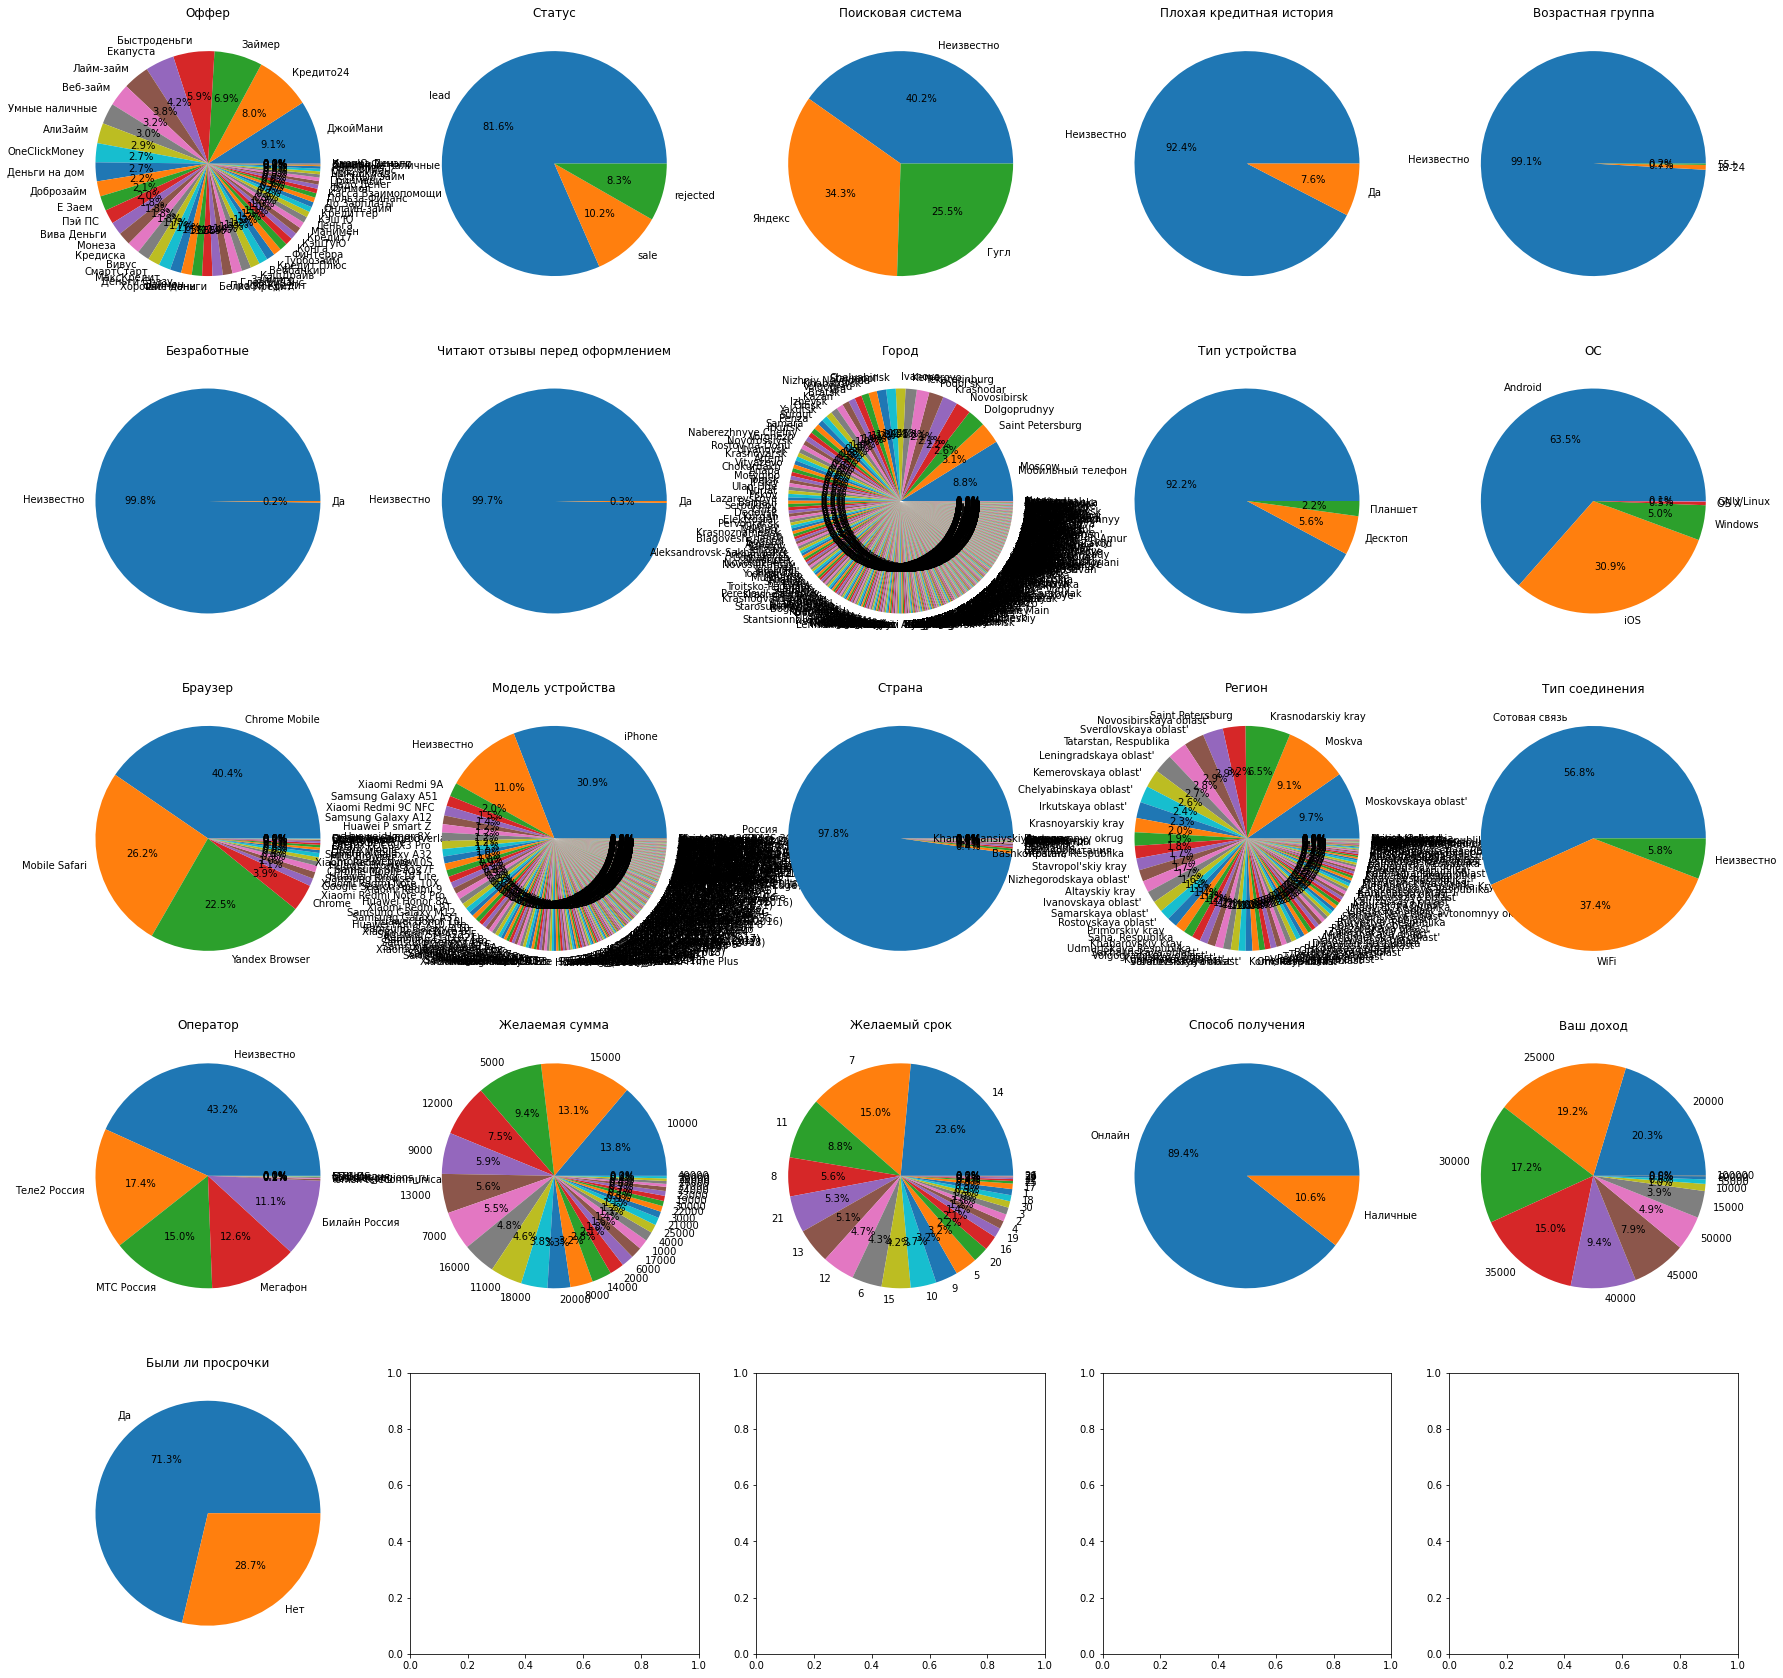

In [5]:
data = data.drop([
    'Время конверсии',
    'Версия браузера',
    'Версия ОС',
    'IP',
    'UserAgent'], axis=1)
    
f, axes= plt.subplots(5, 5, figsize=(30,30))

for i in range(5):
    for j in range(5):
        if(i*5+j)>=21: break
        axes[i,j].pie(
            data[data.columns[i*5+j]].value_counts(),
            labels=[data[data.columns[i*5+j]].value_counts().index[k] for k in range(len(data[data.columns[i*5+j]].value_counts()))],
            autopct='%1.1f%%',
            radius= 1,
            textprops={'color':"black"}
        )
        axes[i,j].set_title(data.columns[i*5+j], fontdict={'color':"black"})
        #axes[i,j].legend()

plt.show()

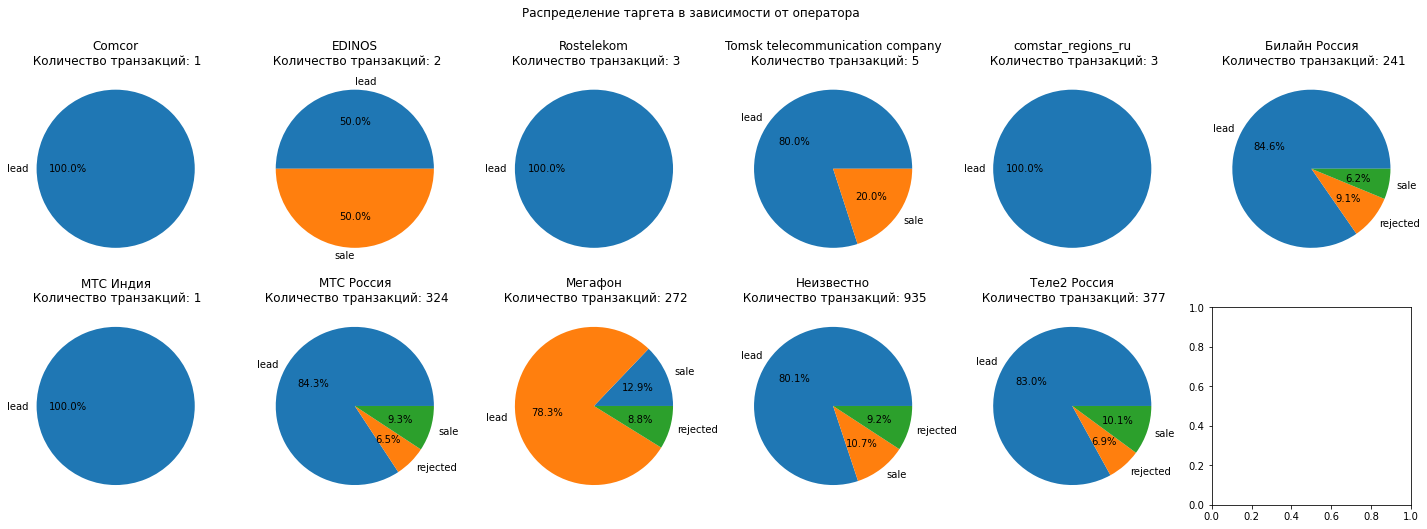

In [9]:
targ_career_distr = pd.DataFrame(data.groupby('Оператор')['Статус'])

f, axes= plt.subplots(2,6, figsize=(25,8))

for i in range(2):
    for j in range(6):
        if(i*6+j)>=11: break
        axes[i,j].pie(
            pd.Series(collections.Counter(targ_career_distr[1][i*6+j])),
            labels=list(collections.Counter(targ_career_distr[1][i*6+j])),
            autopct='%1.1f%%',
            radius= 1,
            textprops={'color':"black"}
        )
        axes[i,j].set_title(f'{list(targ_career_distr[0])[i*6+j]}\n Количество транзакций: {pd.Series(collections.Counter(targ_career_distr[1][i*6+j])).sum()}', fontdict={'color':"black"})

f.suptitle('Распределение таргета в зависимости от оператора',y=0.99)
plt.show()

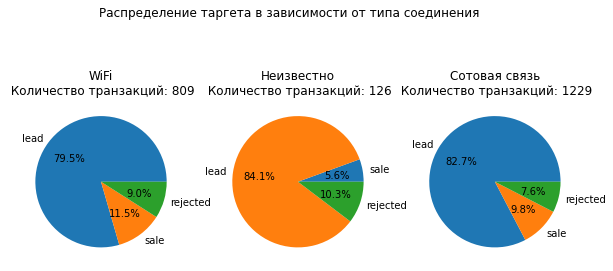

In [8]:
targ_connection_distr = pd.DataFrame(data.groupby('Тип соединения')['Статус'])
f, axes= plt.subplots(1,3, figsize=(10,5))

for i in range(3):
    axes[i].pie(
        pd.Series(collections.Counter(targ_connection_distr[1][i])),
        labels=list(collections.Counter(targ_connection_distr[1][i])),
        autopct='%1.1f%%',
        radius= 1,
        textprops={'color':"black"}
    )
    axes[i].set_title(f'{list(targ_connection_distr[0])[i]}\n Количество транзакций: {pd.Series(collections.Counter(targ_connection_distr[1][i])).sum()}', fontdict={'color':"black"})

f.suptitle('Распределение таргета в зависимости от типа соединения',y=0.99)
plt.show()

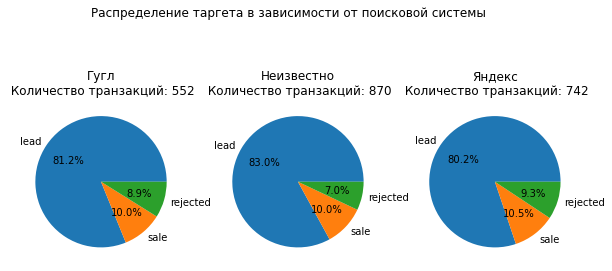

In [7]:
targ_search_distr = pd.DataFrame(data.groupby('Поисковая система')['Статус'])
f, axes= plt.subplots(1,3, figsize=(10,5))

for i in range(3):
    axes[i].pie(
        pd.Series(collections.Counter(targ_search_distr[1][i])),
        labels=list(collections.Counter(targ_search_distr[1][i])),
        autopct='%1.1f%%',
        radius= 1,
        textprops={'color':"black"}
    )
    axes[i].set_title(f'{list(targ_search_distr[0])[i]}\n Количество транзакций: {pd.Series(collections.Counter(targ_search_distr[1][i])).sum()}', fontdict={'color':"black"})

f.suptitle('Распределение таргета в зависимости от поисковой системы',y=0.99)
plt.show()

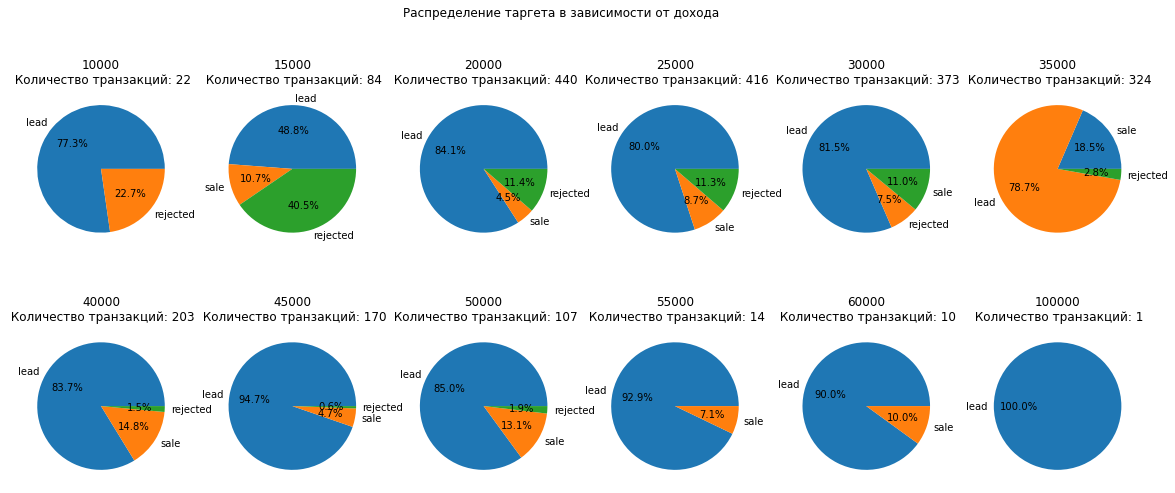

In [132]:
targ_income_distr = pd.DataFrame(data.groupby('Ваш доход')['Статус'])
f, axes= plt.subplots(2,6, figsize=(20,8))

for i in range(2):
    for j in range(6):
        axes[i,j].pie(
            pd.Series(collections.Counter(targ_income_distr[1][i*6+j])),
            labels=list(collections.Counter(targ_income_distr[1][i*6+j])),
            autopct='%1.1f%%',
            radius= 1,
            textprops={'color':"black"}
        )
        axes[i,j].set_title(f'{list(targ_income_distr[0])[i*6+j]}\n Количество транзакций: {pd.Series(collections.Counter(targ_income_distr[1][i*6+j])).sum()}', fontdict={'color':"black"})

f.suptitle('Распределение таргета в зависимости от дохода',y=0.99)
plt.show()

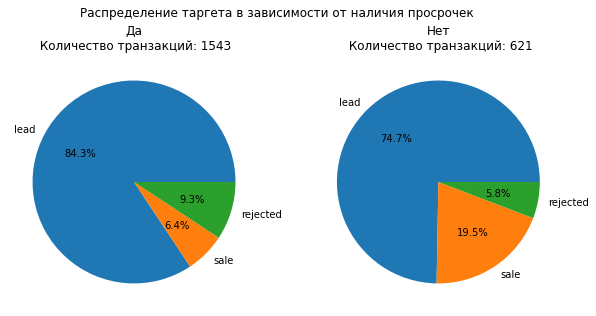

In [10]:
targ_overdue_distr = pd.DataFrame(data.groupby('Были ли просрочки')['Статус'])
f, axes= plt.subplots(1,2, figsize=(10,5))

for i in range(2):
    axes[i].pie(
        pd.Series(collections.Counter(targ_overdue_distr[1][i])),
        labels=list(collections.Counter(targ_overdue_distr[1][i])),
        autopct='%1.1f%%',
        radius= 1,
        textprops={'color':"black"}
    )
    axes[i].set_title(f'{list(targ_overdue_distr[0])[i]}\n Количество транзакций: {pd.Series(collections.Counter(targ_overdue_distr[1][i])).sum()}', fontdict={'color':"black"})

f.suptitle('Распределение таргета в зависимости от наличия просрочек',y=0.99)
plt.show()

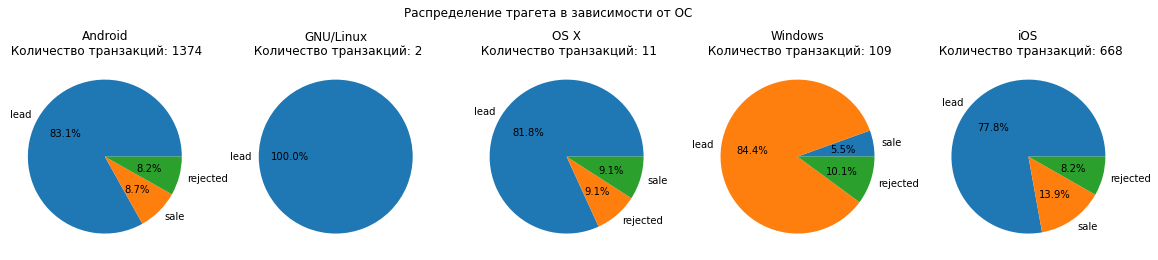

In [5]:
oc_overdue_distr = pd.DataFrame(data.groupby('ОС')['Статус'])
f, axes= plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    axes[i].pie(
        pd.Series(collections.Counter(oc_overdue_distr[1][i])),
        labels=list(collections.Counter(oc_overdue_distr[1][i])),
        autopct='%1.1f%%',
        radius= 1,
        textprops={'color':"black"}
    )
    axes[i].set_title(f'{list(oc_overdue_distr[0])[i]}\n Количество транзакций: {pd.Series(collections.Counter(oc_overdue_distr[1][i])).sum()}', fontdict={'color':"black"})

f.suptitle('Распределение трагета в зависимости от ОС',y=0.92)
plt.show()

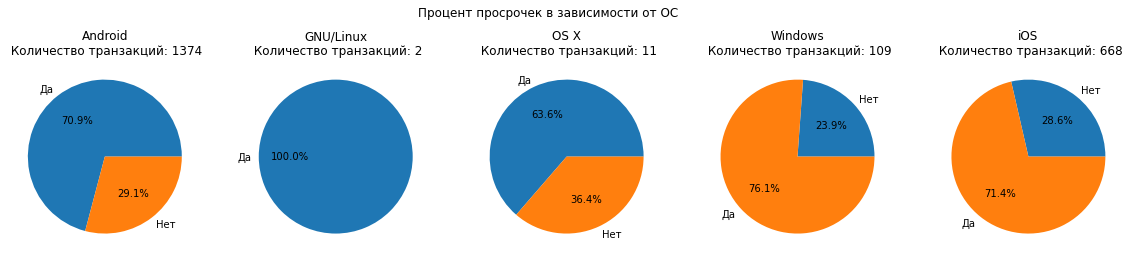

In [47]:
oc_overdue_distr = pd.DataFrame(data.groupby('ОС')['Были ли просрочки'])
f, axes= plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    axes[i].pie(
        pd.Series(collections.Counter(oc_overdue_distr[1][i])),
        labels=list(collections.Counter(oc_overdue_distr[1][i])),
        autopct='%1.1f%%',
        radius= 1,
        textprops={'color':"black"}
    )
    axes[i].set_title(f'{list(oc_overdue_distr[0])[i]}\n Количество транзакций: {pd.Series(collections.Counter(oc_overdue_distr[1][i])).sum()}', fontdict={'color':"black"})

f.suptitle('Процент просрочек в зависимости от ОС',y=0.92)
plt.show()

In [6]:
offer_distr = pd.DataFrame(data.groupby('Оффер')['Статус'])
f, axes= plt.subplots(7, 8, figsize=(20,20),dpi= 500)

for i in range(7):
    for j in range(8):
        axes[i,j].pie(
            pd.Series(collections.Counter(offer_distr[1][i*8+j])),
            labels=list(collections.Counter(offer_distr[1][i*8+j])),
            autopct='%1.1f%%',
            radius= 1,
            textprops={'color':"black"}
        )
        axes[i,j].set_title(list(offer_distr[0])[i*8+j], fontdict={'color':"black"})

f.suptitle('Статус таргета отностиельно МФО',y=0.92)
plt.show()

Построим диаграмму распределений

In [ ]:
data = data.drop(['UserAgent','Время конверсии','Версия браузера','IP','Версия ОС'],axis=1)
data = data.fillna('Пропущено')

f, axes= plt.subplots(5, 5, figsize=(20,15))

for i in range(5):
    for j in range(5):
        axes[i,j].pie(
            data[data.columns[i*4+j]].value_counts(),
            labels=[data[data.columns[i*4+j]].value_counts().index[k] for k in range(len(data[data.columns[i*4+j]].value_counts()))],
            autopct='%1.1f%%',
            radius= 1,
            textprops={'color':"black"}
        )
        axes[i,j].set_title(data.columns[i*4+j], fontdict={'color':"black"})

plt.show()

# Чистка сета

Удаляем признаки (есть обоснования)

In [6]:
data = data.drop([
    'Время конверсии',
    'Браузер',
    'Версия браузера',
    'Плохая кредитная история',
    'Возрастная группа',
    'Безработные',
    'Читают отзывы перед оформлением',
    'ОС',
    'Версия ОС',
    'Тип устройства',
    'Поисковая система',
    'Тип соединения',
    'Оператор',
    'Модель устройства',
    'UserAgent'], axis=1)

Удалим признаки на шару (без доказательства)

In [7]:
data = data.drop([
    'Город',
    'Страна',
    'IP',
    'Регион',], axis=1)

Заменим категории чиселками

In [8]:
data['Статус'][data['Статус']=='sale'] = 0
data['Статус'][data['Статус']=='rejected'] = 1
data['Статус'][data['Статус']=='lead'] = 2
data['Статус'] = pd.to_numeric(data['Статус'])

to_num= {
    'sale' : 0,
    'rejected' : 1,
    'lead': 2,
}

to_val = {
    0:'sale',
    1:'rejected',
    2:'lead',
}

data = data.replace(2,1)#ЗАМЕНИМ LEAD на REJECTED

data['Были ли просрочки'][data['Были ли просрочки']=='Нет'] = 0
data['Были ли просрочки'][data['Были ли просрочки']=='Да'] = 1
data['Были ли просрочки'] = pd.to_numeric(data['Были ли просрочки'])

data['Способ получения'][data['Способ получения']=='Наличные'] = 0
data['Способ получения'][data['Способ получения']=='Онлайн'] = 1
data['Способ получения'] = pd.to_numeric(data['Способ получения'])


data['Желаемая сумма'] = data['Желаемая сумма'].apply(math.log)
data['Ваш доход'] = data['Ваш доход'].apply(math.log)


None

C:\Users\Nigel\AppData\Local\Temp\ipykernel_14724\946372091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Статус'][data['Статус']=='sale'] = 0
C:\Users\Nigel\AppData\Local\Temp\ipykernel_14724\946372091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Статус'][data['Статус']=='rejected'] = 1
C:\Users\Nigel\AppData\Local\Temp\ipykernel_14724\946372091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Статус'

Обработка датасета. Ячейка с бинарным кодированием и куклами 🎎🪆

In [9]:
# data = pd.concat([data, pd.get_dummies(data['Поисковая система'])],axis=1)
# data = data.drop(['Поисковая система'], axis=1)

bn = BinaryEncoder()

# data = pd.concat([data, bn.fit_transform(data['Страна'])], axis=1)
# data = data.drop(['Страна'], axis=1)
# data = pd.concat([data, bn.fit_transform(data['Город'])], axis=1)
# data = data.drop(['Город','Версия браузера'], axis=1)

# data = data.drop(['Регион'], axis=1)
# data = pd.concat([data, bn.fit_transform(data['Тип соединения'])], axis=1)
# data = data.drop(['Тип соединения'], axis=1)
# data = pd.concat([data, bn.fit_transform(data['Оператор'])], axis=1)
# data = data.drop(['Оператор'], axis=1)


# data['*item*'] = data['*item*'].fillna(0)
# data['*item*'][data['*item*']=='*value*'] = int(1)

# data['Плохая кредитная история'] = pd.to_numeric(data['Плохая кредитная история'])
# data['Безработные'] = pd.to_numeric(data['Безработные'])
# data['Читают отзывы перед оформлением'] = pd.to_numeric(data['Читают отзывы перед оформлением'])

In [10]:
D = dict(data.groupby('Оффер')['Статус'].mean())
data['Оффер'] = data['Оффер'].apply(lambda x: D[x])

In [47]:
data = pd.concat([data, bn.fit_transform(data['Оффер'])], axis=1)
data = data.drop(['Оффер'],axis=1)

переставим оффер в конец

In [11]:
data_cols = list(data.columns)
data_cols.append(data_cols[0])
data_cols.pop(0)
data_cols

data = data[data_cols]

In [12]:
data

Статус  Желаемая сумма  Желаемый срок  Способ получения  Ваш доход  \
0          1       10.126631             15                 1   9.210340   
1          1        8.853665              6                 1  10.308953   
2          1        9.798127             14                 1   9.903488   
3          1        9.472705             15                 1   9.903488   
4          1       10.275051              8                 1   9.615805   
...      ...             ...            ...               ...        ...   
2159       0        7.600902              8                 1   9.903488   
2160       1        9.615805             14                 1   9.903488   
2161       1        9.392662             14                 1  10.308953   
2162       1       10.043249              7                 1  10.308953   
2163       1       10.085809              1                 1  10.308953   

      Были ли просрочки     Оффер  
0                     0  0.921875  
1                     0  0.800000  
2                     1  0.888325  
3                     1  1.000000  
4                     1  0.875000  
...                 ...       ...  
2159                  1  0.846667  
2160                  1  1.000000  
2161                  1  1.000000  
2162                  0  0.888325  
2163                  1  0.925000  

[2164 rows x 7 columns]

# ТЕСТ МОДЕЛЕЙ

In [13]:
class DatasetParser():
    def __init__(self, data:pd.DataFrame):
        self.annonations = data
    
    def __len__(self):
        return len(self.annonations)
    
    def __getitem__(self, index):
        x_labels = torch.tensor(self.annonations.iloc[:,1:].iloc[[index]].values.squeeze().astype(np.float32))
        
        y_labels = torch.tensor(self.annonations.iloc[:,:1].iloc[[index]].values.squeeze().astype(np.int64))

        return (x_labels, y_labels)

dataset = DatasetParser(data)
train_set, test_set = torch.utils.data.random_split(dataset, [1500,664])# получаем 2 рандомно составлнных сета итерированием объекта DatasetParser. Возвращент:<class 'torch.utils.data.dataset.Subset'>
#[110000,1873]

In [14]:
train_loader = DataLoader(dataset=train_set, batch_size=15, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)

# нейрон04ка

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class linearRegression(nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(6, 2)

    def forward(self, x):
        out = F.relu(self.linear(x))
        return out


class simpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # self.mp = nn.MaxPool1d(kernel_size=2,stride=2)

        self.conv1 = nn.Conv1d(1,16, kernel_size=2)
        self.conv2 = nn.Conv1d(16,32, kernel_size=2)
        self.conv3 = nn.Conv1d(32,16, kernel_size=2)

        self.fc1 = nn.Linear(3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 2)
    
    def forward(self, x:torch.tensor):

        x = F.relu(self.conv1(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x


def train(net, n_epoch=7):
    loss_fn = torch.nn.CrossEntropyLoss()
    loss_mass = []
    loss_mass_test = []

    learning_rate = 0.001
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    test_dataiter = iter(test_loader)
    X_batch_test, y_batch_test = test_dataiter.next()

    for epoch in tqdm(range(n_epoch)):

        train_dataiter = iter(train_loader)

        for i, batch in enumerate(train_dataiter):
                X_batch, y_batch = batch
                
                optimizer.zero_grad()

                y_pred = net(X_batch)
                y_pred_test = net(X_batch_test)
                loss = loss_fn(y_pred, y_batch)
                loss_test = loss_fn(y_pred_test, y_batch_test)
                loss_mass.append(float(loss.item()))
                loss_mass_test.append(float(loss_test.item()))
                
                loss.backward()
                loss_test.backward()
                
                optimizer.step()
        
        
    plt.title('Loss')
    plt.plot(loss_mass)
    plt.plot(loss_mass_test)
    plt.legend(['Train set','Test set'])
    plt.show()

    print('Обучение закончено')
    return net

In [ ]:
net = simpleNet()
#net = linearRegression()
net = train(net)

test_dataiter = iter(test_loader)
objects, names = test_dataiter.next()
print(accuracy_score(names.numpy(), np.argmax(net(objects).detach().numpy(), axis=1)))
print(roc_auc_score(names.numpy(), np.argmax(net(objects).detach().numpy(), axis=1)))

# catboost

In [9]:
data

Статус  Желаемая сумма  Желаемый срок  Способ получения  Ваш доход  \
0          1       10.126631             15                 1   9.210340   
1          1        8.853665              6                 1  10.308953   
2          1        9.798127             14                 1   9.903488   
3          1        9.472705             15                 1   9.903488   
4          1       10.275051              8                 1   9.615805   
...      ...             ...            ...               ...        ...   
2159       0        7.600902              8                 1   9.903488   
2160       1        9.615805             14                 1   9.903488   
2161       1        9.392662             14                 1  10.308953   
2162       1       10.043249              7                 1  10.308953   
2163       1       10.085809              1                 1  10.308953   

      Были ли просрочки     Оффер  
0                     0  0.921875  
1                     0  0.800000  
2                     1  0.888325  
3                     1  1.000000  
4                     1  0.875000  
...                 ...       ...  
2159                  1  0.846667  
2160                  1  1.000000  
2161                  1  1.000000  
2162                  0  0.888325  
2163                  1  0.925000  

[2164 rows x 7 columns]

In [ ]:
feature_cols = ['Оффер','Желаемая сумма','Желаемый срок','Способ получения','Ваш доход','Были ли просрочки']
import catboost as ctb
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data['Статус'], test_size=0.3, random_state=0)

y_train = pd.to_numeric(y_train)
y_test = pd.to_numeric(y_test)  

catb = ctb.CatBoostClassifier(num_trees=100, learning_rate=0.4, custom_loss='AUC').fit(X_train, y_train, verbose=False)
catb.predict(X_test)
print(catb.score(X_test,y_test))

# feat_df = pd.DataFrame(catb.feature_importances_, index = X_train.columns, columns=['importance'])
# feat_df.plot(kind= 'barh', figsize= (20, 20))

print('roc-auc: ',roc_auc_score(y_test, catb.predict(X_test)))